In [2]:
import numpy as np
import scipy as sp
import scipy.signal as sps
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<style>
h1 {
    font-size: 28pt
}
h2 {
    font-size: 20pt
}
h3 {
    font-size: 16pt
}
p {
    font-size: 12pt
}
code {
    font-size: 12pt
}
ul {
    font-size: 12pt
}
</style>

# __Homework 15 - Fourier transforms__

# Excercise 1
Here is some incomplete code to simulate the arrival of two photons into a gamma detector at two time points. This non-periodic example has no natural frequency. 

- Add random electronics noise to the signal and calculate the auto correlation function. Provide an interpretation what you find. What peaks are there in the autocorrelation and why do they appear there?
- Calculate the the power spectral density in dB directly from the signal and also the signal+noise. Don't worry about the power spectrum of the autocorrelation. Estimate the level of noise in dB as a function of the added noise. What frequencies does the the power spectrum of the signal exceed the noise?

```python
# -- Dummy data with noise
# -- Two Guassian peaks indicating the arrival of a photon at two time points
sampling_rate   = 10                    # Hz 
delta_t         = 1.0/sampling_rate     # sec
N               = 2**9                  # power of 2 
signal_time1    = 26                    # sec
signal_time2    = 15                    # sec
signal_duration = 0.6                   # sec
noise_sigma     = 0.4

signal = (numpy.exp(-1*(t-signal_time1)**2/(2*signal_duration**2)) +
          numpy.exp(-1*(t-signal_time2)**2/(2*signal_duration**2)))
```

<font color="blue">**Answer**:</font>


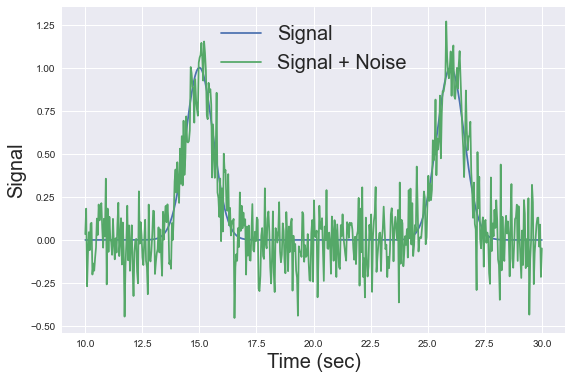

In [3]:
# -- Dummy data with noise
# -- Two Guassian peaks indicating the arrival of a photon at two time points
sampling_rate = 10  # Hz
dt = 1.0/sampling_rate  # sec
N = 2**9  # power of 2
signal_time1 = 26  # sec
signal_time2 = 15  # sec
signal_duration = 0.6  # sec
noise_sigma = 0.4

t_min = 10
t_max = 30

t, dt = np.linspace(t_min, t_max, N, retstep=True)

noise = noise_sigma * np.random.normal(loc=0.0, scale=noise_sigma, size=N)

signal = (
    np.exp(-1*(t-signal_time1)**2/(2*signal_duration**2)) +
    np.exp(-1*(t-signal_time2)**2/(2*signal_duration**2))
)

noisy_signal = signal + noise

plt.figure(figsize=(9, 6))

plt.plot(t, signal, label='Signal')
plt.plot(t, noisy_signal, label='Signal + Noise')
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)

plt.legend(fontsize=20)
plt.show()
plt.close()


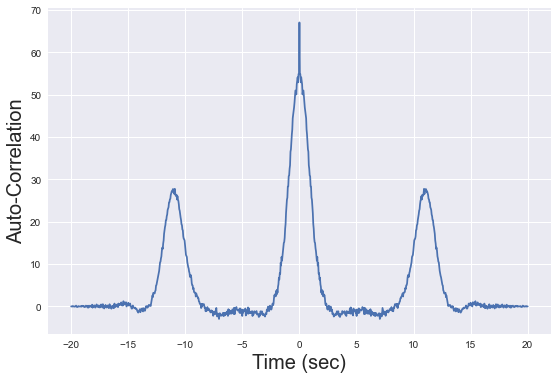

In [4]:
corr_signal = sps.correlate(noisy_signal, noisy_signal, mode="full")
tau_min = -(N-1)*dt
tau_max = (N-1)*dt
tau = np.linspace(tau_min, tau_max, 2*N-1)

plt.figure(figsize=(9, 6))
plt.plot(tau, corr_signal)
plt.ylabel("Auto-Correlation", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.show()
plt.close()


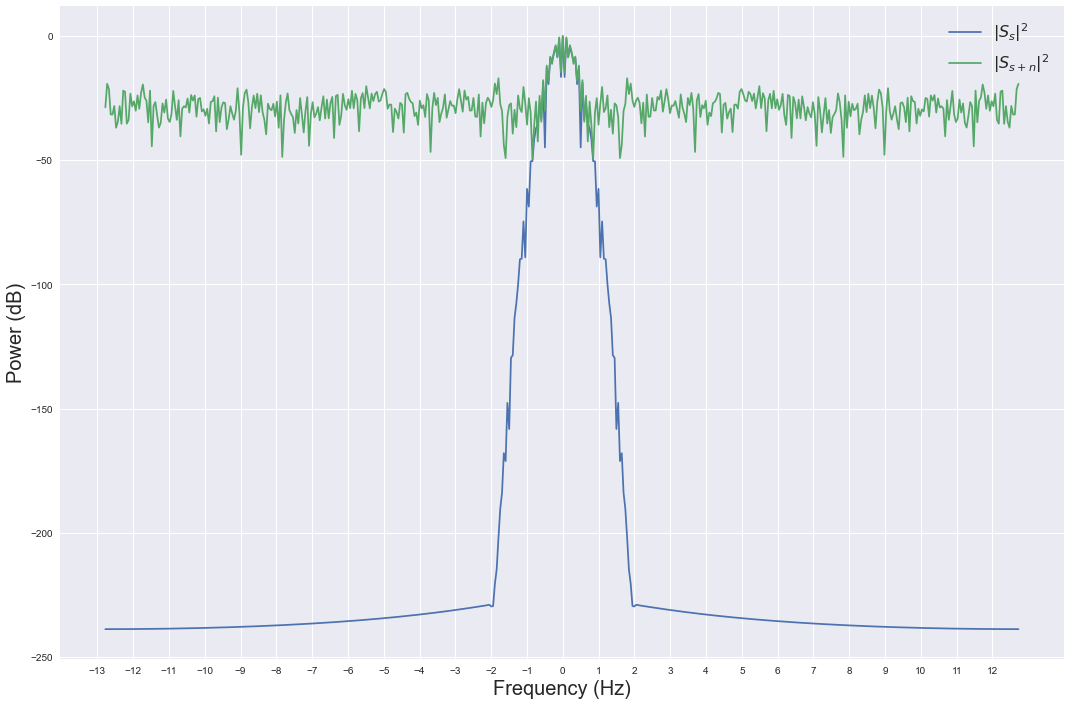

In [5]:
# -- Calculate the FFT of the correlation of the signal+noise = power spectrum
fft_corr_signal = sp.fft.fft(corr_signal)
freq_corr_signal = sp.fft.fftfreq(fft_corr_signal.size, dt)

# -- Calculate the FFT of both the signal, and the signal + noise
fft_signal = sp.fft.fft(signal)
fft_signal_noise = sp.fft.fft(noisy_signal)
freq_signal = sp.fft.fftfreq(fft_signal.size, dt)

# -- We will show the FFT in terms of decibels
fft_signal_db = 10*np.log10(
    np.abs(fft_signal**2/np.max(fft_signal)**2)
)
fft_signal_noise_db = 10*np.log10(
    np.abs(fft_signal_noise**2/np.max(fft_signal_noise)**2)
)

fft_corr_signal = sp.fft.fftshift(fft_corr_signal)

fft_signal_db = sp.fft.fftshift(fft_signal_db)
fft_signal_noise_db = sp.fft.fftshift(fft_signal_noise_db)
freq_signal = sp.fft.fftshift(freq_signal)

plt.figure(figsize=(18, 12))

plt.plot(freq_signal, fft_signal_db, label=r"$|S_{s}|^2$")
plt.plot(freq_signal, fft_signal_noise_db, label=r"$|S_{s+n}|^2$")

plt.xticks(np.arange(np.floor(min(freq_signal)), np.ceil(max(freq_signal)), 1))

plt.ylabel("Power (dB)", fontsize=20)
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.legend(fontsize=16)
plt.show()
plt.close()


<style>
h1 {
    font-size: 28pt
}
h2 {
    font-size: 20pt
}
h3 {
    font-size: 16pt
}
p {
    font-size: 12pt
}
code {
    font-size: 12pt
}
ul {
    font-size: 12pt
}
</style>

## __Interpretation__

As can be seen in the auto-correlation plot, it can be concluded that the signal is in fact very similar to itself when shifter in time by $0$ seconds. Then, when the signal is shifted in time by approximately $11$ seconds as seen in the plot (as expected as $t1 - t2 = 11$), we see that the signal is slightly similar. This is because one of the peaks will be overlapping the other peak at a time shift of $\tau \approx 11$, but the other one will not be, and of course this is symmetric.

The power spectrum of the noisy signal exceeds the noise for frequencies that are around $1$ or less Hertz.


<style>
h1 {
    font-size: 28pt
}
h2 {
    font-size: 20pt
}
h3 {
    font-size: 16pt
}
p {
    font-size: 12pt
}
code {
    font-size: 12pt
}
ul {
    font-size: 12pt
}
</style>

# Excercise 2

Let the signal be exactly one period of the function
$$s(t)=\frac{1}{1-0.9\sin(2\pi f_0t)}$$
Where $f_0$ is the signal frequency and $a$ is the amplitude. Add noise to your signal and filter using the windows sinc function method shown in the lecture notebook.

- Use [`numpy.random.Generator.normal`][1] with an amplitude of 1 for the noise.
- Plot the signal, the signal+noise, and the filtered signal+noise.

Because the sinc function is cut off at the limits of the time window, we should dampen the fluctuations near the edges of the time period with a <a href="https://en.wikipedia.org/wiki/Window_function">window function</a>. Use `scipy.signal.get_window` to create a `blackman` window of length $N$, and apply (multiply) it to your filter in the time domain, ahead of fourier transforming it.

[1]: https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal

<font color="blue">**Answer:**</font>

In [6]:
cycles = 1
N = 2**10
signal_freq = 0.9
noise_sigma = 0.8
t_min = 0
t_max = cycles / signal_freq
t, dt = np.linspace(t_min, t_max, N, retstep=True, endpoint=True)

sampling_rate = 1 / dt
nyq_rate = sampling_rate / 2
cutoff_freq = 0.02 * nyq_rate

print("Sampling rate     : {0:4.3f} Hz.".format(sampling_rate))
print("Nyquist frequency : {0:4.3f} Hz.".format(nyq_rate))
print("Cutoff frequency  : {0:4.3f} Hz.".format(cutoff_freq))

signal = 1 / (1 - 0.9 * np.sin(2 * np.pi * signal_freq * t))
noise = noise_sigma * np.random.normal(loc=0, scale=noise_sigma, size=N)

noisy_signal = signal + noise


Sampling rate     : 920.700 Hz.
Nyquist frequency : 460.350 Hz.
Cutoff frequency  : 9.207 Hz.


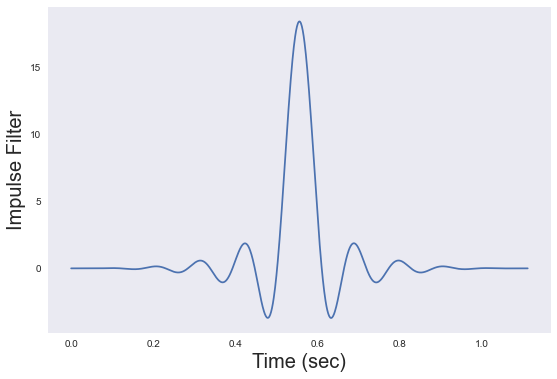

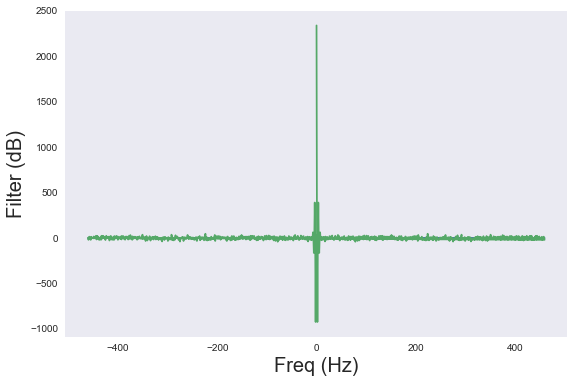

In [7]:
# Blackman window
window = sps.get_window("blackman", N)

# Fourier Transform
filter = window * np.sin(2*np.pi*cutoff_freq*(t-t_max/2))/(np.pi*(t-t_max/2))
sinc_filter = sp.fft.fft(filter)
sinc_filter = sinc_filter/np.max(sinc_filter)
sinc_filter_freq = sp.fft.fftfreq(sinc_filter.size, dt)

# Inverse Fourier Transform
fft_signal_noise = sp.fft.fft(signal+noise)
smoothed_fft_signal_noise = np.abs(sinc_filter)*fft_signal_noise
smoothed_signal = sp.fft.ifft(smoothed_fft_signal_noise)

# Plots
plt.figure(figsize=(9, 6))
plt.plot(t, filter)
plt.ylabel("Impulse Filter", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.grid()
plt.show()
plt.close()

plt.figure(figsize=(9, 6))
plt.plot(np.real(sinc_filter_freq), np.real(sinc_filter))
plt.plot(np.real(sinc_filter_freq), np.real(fft_signal_noise))
plt.ylabel("Filter (dB)", fontsize=20)
plt.xlabel("Freq (Hz)", fontsize=20)
plt.grid()
plt.show()
plt.close()

fft_signal_noise = sp.fft.fft(noisy_signal)
smoothed_fft_signal_noise = np.abs(sinc_filter) * fft_signal_noise
smoothed_signal = sp.fft.ifft(smoothed_fft_signal_noise)


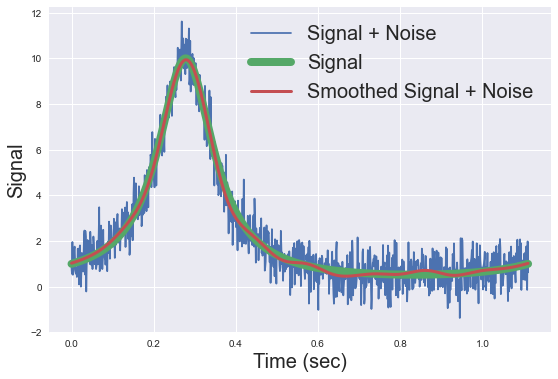

In [8]:
plt.figure(figsize=(9, 6))

plt.plot(t, np.real(noisy_signal), label='Signal + Noise')
plt.plot(t, np.real(signal), linewidth=8, label='Signal')
plt.plot(t, np.real(smoothed_signal), linewidth=3, label='Smoothed Signal + Noise')
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)

plt.legend(fontsize=20)
plt.show()
plt.close()

<style>
h1 {
    font-size: 28pt
}
h2 {
    font-size: 20pt
}
h3 {
    font-size: 16pt
}
p {
    font-size: 12pt
}
code {
    font-size: 12pt
}
ul {
    font-size: 12pt
}
</style>

# Excercise 3

For this excerise, copy and use the code that makes the noisy cosine function found in the "Windowed sinc function" from the lecture notebook.

* <font color="orange">Create a Hamming FIR filter (similar to the one above) using</font>

```python
weights  = scipy.signal.firwin(nw, fc, window=('hamming'))
```

where `nw` is the number of weights $b_j$, and `fc` is the cuttoff frequency as a fraction of the Nyquist frequency. Let `nw` be $1/4$ or less the number of signal points, ie. `nw=N//4`. 

* <font color="orange">Make a plot of the weights that were returned, without a specific time-axis. It should look like a sinc function.</font>

-------------------

The filtered signal is then computed by 

```python
scipy.signal.lfilter(weights, 1.0, signal+noise)
```

The time delay imposed by the FIR is given by
$$
t_d = \frac{(N_w-1)}{2f_s},
$$ 
where $f_s$ is the sampling rate.

* <font color="orange">Make a plot of both the filtered and noisy signals as a function of time, with the filtered signal shifted in time by the amount above.</font>

The frequency response of the filter is important to know, even if we are doing the filtering in the time domain  and not in the frequency domain. You can compute the expected frequency response of the FIR filter with 

```python
scipy.signal.freqz(weights, 1.0, worN=N)
```

Here I have chosen to compute the frequency at the same number of points as the FFT of the signal for convienience. This function returns the amplitude of the frequency filter, as well as the frequencies $f'\geq0$, but giiven as a fraction of the Nyquist frequency

$$
f= f_N\times \frac{f'}{\pi}
$$

* <font color="orange">Make a plot of the frequency filter and the FFT of the noisy signal, showing only the positive frequencies.</font>

<font color="orange">Is the cutoff what you expected? What is different about the frequency filter from the one you made above?</font>

A <a href="https://en.wikipedia.org/wiki/Kaiser_window">Kaiser filter</a> allows you to tune the width of the fall-off of the frequency filter, as well as the amplitude of the ripples at high frequency. 

*  <font color="orange">Create a Kaiser window with</font>

```python
nweights, beta = scipy.signal.kaiserord(ripple_db, width)
weights = scipy.signal.firwin(nweights, fc, window=('kaiser', beta))
```     

where `width` is the width in Hz, also expressed as a fraction of the Nyquist frequency, and `ripple_db` is set to be about 50 dB. 

* <font color="orange">Make the same plots of the weights, filtered signal, and frequency reponse as before</font>

Sampling rate     : 230.400 Hz.
Nyquist frequency : 115.200 Hz.
Cutoff frequency  : 2.304 Hz.


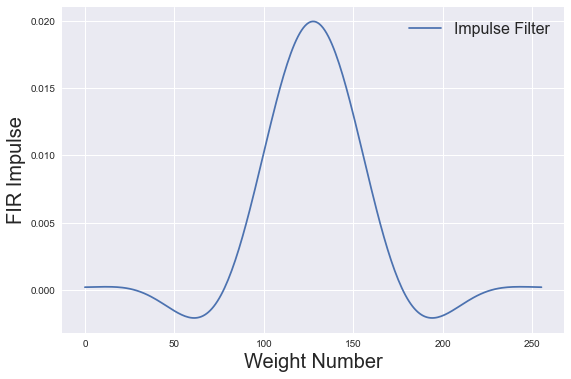

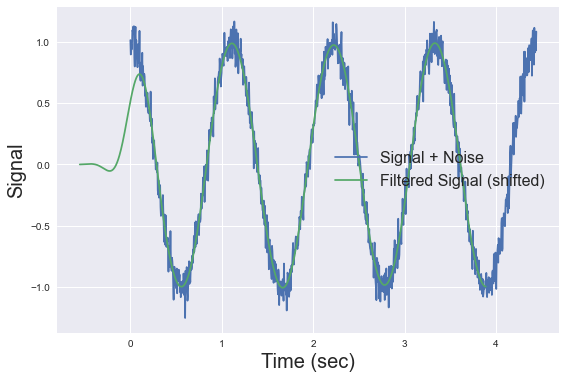

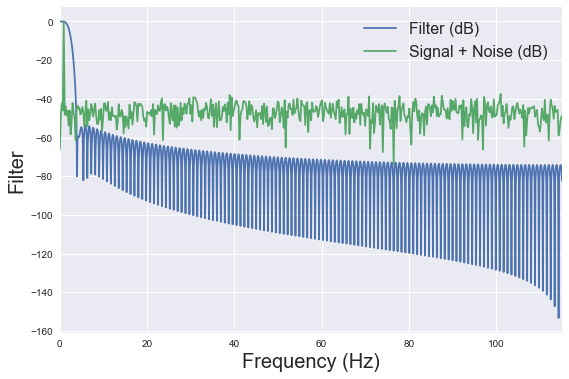

In [9]:
def HAMMING():
    # -- Dummy data with noise
    cycles = 4                 # integer
    N = 2**10             # power of 2
    signal_freq = 0.9               # Hz
    noise_sigma = 0.3               #
    t_min = 0.0                    # sec
    t_max = cycles/signal_freq     # sec
    t, delta_t = np.linspace(
        t_min, 
        t_max, 
        N, 
        retstep=True, 
        endpoint=False
    )  # sec
    sampling_rate = 1.0 / delta_t            # Hz
    nyq_rate = sampling_rate / 2.0    # Hz
    cutoff_freq = 0.02 * nyq_rate         # Hz
    
    print("Sampling rate     : {0:4.3f} Hz.".format(sampling_rate))
    print("Nyquist frequency : {0:4.3f} Hz.".format(nyq_rate))
    print("Cutoff frequency  : {0:4.3f} Hz.".format(cutoff_freq))
    
    signal = np.cos(2*np.pi*signal_freq*t)
    noise = noise_sigma*np.random.normal(loc=0, scale=noise_sigma, size=N)

    # -- HAMMING FILTER
    nweights = N//4
    weights = sp.signal.firwin(nweights, cutoff_freq/nyq_rate, window=('hamming'))
    filtered_signal = sp.signal.lfilter(weights, 1.0, signal+noise)
    delay = 0.5 * (nweights-1) / sampling_rate

    # -- Let's look at the filter in frequency space
    filter_frequencies, filter_amplitude = sp.signal.freqz(weights, 1.0, worN=N)
    filter_frequencies = (filter_frequencies/np.pi)*nyq_rate
    filter_dB = 10*np.log10(
        np.abs(filter_amplitude**2 / np.max(filter_amplitude)**2)
    )

    plt.figure(figsize=(9, 6))
    plt.plot(weights, label="Impulse Filter")
    plt.ylabel("FIR Impulse", fontsize=20)
    plt.xlabel("Weight Number", fontsize=20)
    plt.legend(fontsize=16)
    plt.show()
    plt.close()


    plt.figure(figsize=(9, 6))
    plt.plot(t, signal+noise, label="Signal + Noise")
    plt.plot(t-delay, filtered_signal, label="Filtered Signal (shifted)")
    plt.ylabel("Signal", fontsize=20)
    plt.xlabel("Time (sec)", fontsize=20)
    plt.legend(fontsize=16)
    plt.show()
    plt.close()

    fft_signal_noise = sp.fft.fft(signal+noise)
    fft_signal_noise = 10 * np.log10(
        np.abs(fft_signal_noise**2 / np.max(fft_signal_noise)**2)
    )
    fft_signal_noise = sp.fft.fftshift(fft_signal_noise)
    fft_signal_freq = sp.fft.fftfreq(fft_signal_noise.size, delta_t)
    fft_signal_freq = sp.fft.fftshift(fft_signal_freq)

    plt.figure(figsize=(9, 6))
    plt.plot(filter_frequencies, filter_dB, label="Filter (dB)")
    plt.plot(fft_signal_freq, fft_signal_noise, label="Signal + Noise (dB)")
    plt.xlim(0, np.max(filter_frequencies))
    plt.ylabel("Filter", fontsize=20)
    plt.xlabel("Frequency (Hz)", fontsize=20)
    plt.legend(fontsize=16)
    plt.show()
    plt.close()

HAMMING()

Sampling rate     : 230.400 Hz.
Nyquist frequency : 115.200 Hz.
Cutoff frequency  : 2.304 Hz.


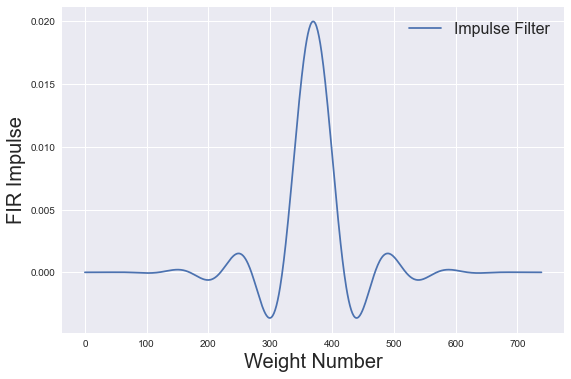

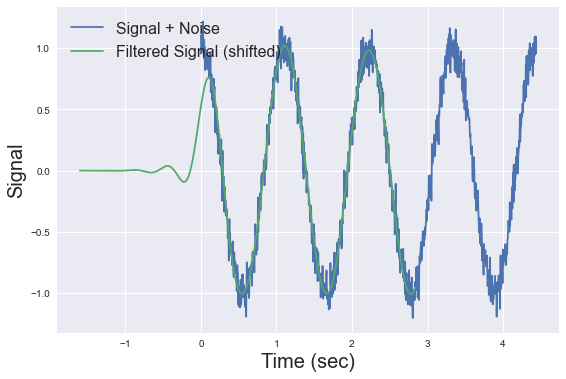

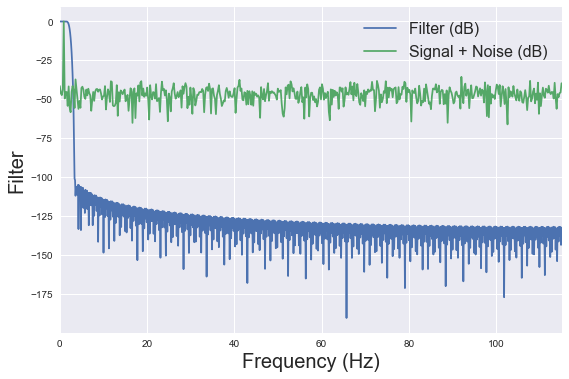

In [10]:
def KAISER():
    # -- Dummy data with noise
    cycles = 4                 # integer
    N = 2**10             # power of 2
    signal_freq = 0.9               # Hz
    noise_sigma = 0.3               #
    t_min = 0.0                    # sec
    t_max = cycles / signal_freq     # sec
    t, delta_t = np.linspace(
        t_min,
        t_max,
        N,
        retstep=True,
        endpoint=False
    )  # sec
    sampling_rate = 1.0 / delta_t            # Hz
    nyq_rate = sampling_rate / 2.0    # Hz
    cutoff_freq = 0.02 * nyq_rate         # Hz
    print("Sampling rate     : {0:4.3f} Hz.".format(sampling_rate))
    print("Nyquist frequency : {0:4.3f} Hz.".format(nyq_rate))
    print("Cutoff frequency  : {0:4.3f} Hz.".format(cutoff_freq))
    signal = np.cos(2*np.pi*signal_freq*t)
    noise = noise_sigma*np.random.normal(loc=0., scale=noise_sigma, size=N)

    # -- KAISER FILTER
    width = 2.0/nyq_rate         # Hz
    ripple_db = 100.0
    nweights, beta = sp.signal.kaiserord(ripple_db, width)
    weights = sp.signal.firwin(
        nweights, 
        cutoff_freq / nyq_rate, 
        window=('kaiser', beta)
    )
    filtered_signal = sp.signal.lfilter(weights, 1.0, signal+noise)
    delay = 0.5 * (nweights-1) / sampling_rate

    # -- Let's look at the filter in frequency space
    filter_frequencies, filter_amplitude = sp.signal.freqz(
        weights, 
        1.0, 
        worN=N
    )
    filter_frequencies = (filter_frequencies/np.pi)*nyq_rate
    filter_dB = 10*np.log10(
        np.abs(filter_amplitude**2 / np.max(filter_amplitude)**2)
    )

    plt.figure(figsize=(9, 6))
    plt.plot(weights, label="Impulse Filter")
    plt.ylabel("FIR Impulse", fontsize=20)
    plt.xlabel("Weight Number", fontsize=20)
    plt.legend(fontsize=16)
    plt.show()
    plt.close()

    plt.figure(figsize=(9, 6))
    plt.plot(t, signal+noise, label="Signal + Noise")
    plt.plot(t-delay, filtered_signal, label="Filtered Signal (shifted)")
    plt.ylabel("Signal", fontsize=20)
    plt.xlabel("Time (sec)", fontsize=20)
    plt.legend(fontsize=16)
    plt.show()
    plt.close()

    fft_signal_noise = sp.fft.fft(signal+noise)
    fft_signal_noise = 10 * np.log10(
        np.abs(fft_signal_noise**2 / np.max(fft_signal_noise)**2)
    )
    fft_signal_noise = sp.fft.fftshift(fft_signal_noise)
    fft_signal_freq = sp.fft.fftfreq(fft_signal_noise.size, delta_t)
    fft_signal_freq = sp.fft.fftshift(fft_signal_freq)

    plt.figure(figsize=(9, 6))
    plt.plot(filter_frequencies, filter_dB, label="Filter (dB)")
    plt.plot(fft_signal_freq, fft_signal_noise, label="Signal + Noise (dB)")
    plt.xlim(0, np.max(filter_frequencies))
    plt.ylabel("Filter", fontsize=20)
    plt.xlabel("Frequency (Hz)", fontsize=20)
    plt.legend(fontsize=16)
    plt.show()
    plt.close()


KAISER()


In [11]:
def UNEEDED():
    pass
    # def BUTTER():
    #     # -- Dummy data with noise
    #     cycles = 4                 # integer
    #     N = 2**10             # power of 2
    #     signal_freq = 0.9               # Hz
    #     noise_sigma = 0.3               #
    #     t_min = 0.0                    # sec
    #     t_max = cycles / signal_freq     # sec
    #     t, delta_t = np.linspace(
    #         t_min, 
    #         t_max, 
    #         N, 
    #         retstep=True, 
    #         endpoint=False
    #     )  # sec
    #     sampling_rate = 1.0/delta_t            # Hz
    #     nyq_rate = sampling_rate / 2.0    # Hz
    #     cutoff_freq = 0.02 * nyq_rate         # Hz
        
    #     print("Sampling rate     : {0:4.3f} Hz.".format(sampling_rate))
    #     print("Nyquist frequency : {0:4.3f} Hz.".format(nyq_rate))
    #     print("Cutoff frequency  : {0:4.3f} Hz.".format(cutoff_freq))
    #     signal = np.cos(2*np.pi*signal_freq*t)
    #     noise = noise_sigma*np.random.normal(loc=0, scale=noise_sigma, size=N)

    #     # -- BUTTER FILTER
    #     weights, weightsa = sp.signal.butter(
    #         4, 
    #         cutoff_freq / nyq_rate, 
    #         btype='low', 
    #         analog=False
    #     )
    #     filtered_signal = sp.signal.lfilter(weights, weightsa, signal+noise)
    #     delay = 0

    #     # -- Let's look at the filter in frequency space
    #     filter_frequencies, filter_dB = sp.signal.freqz(weights, weightsa, worN=N)
    #     filter_frequencies = (filter_frequencies/np.pi)*nyq_rate
    #     filter_dB = 20*np.log10(np.abs(filter_dB**2/np.max(filter_dB)**2))

    #     plt.figure(figsize=(9, 6))
    #     plt.plot(weights, label="Impulse Filter")
    #     plt.ylabel("FIR Impulse", fontsize=20)
    #     plt.xlabel("Weight Number", fontsize=20)
    #     plt.legend(fontsize=16)
    #     plt.show()
    #     plt.close()

    #     plt.figure(figsize=(9, 6))
    #     plt.plot(t, signal+noise, label="Signal + Noise")
    #     plt.plot(t - delay, filtered_signal, label="Filtered Signal (shifted)")
    #     plt.ylabel("Signal", fontsize=20)
    #     plt.xlabel("Time (sec)", fontsize=20)
    #     plt.legend(fontsize=16)
    #     plt.show()
    #     plt.close()

    #     fft_signal_noise = sp.fft.fft(signal+noise)
    #     fft_signal_noise = 10 * np.log10(
    #         np.abs(fft_signal_noise**2 / np.max(fft_signal_noise)**2)
    #     )
    #     fft_signal_noise = sp.fft.fftshift(fft_signal_noise)
    #     fft_signal_freq = sp.fft.fftfreq(fft_signal_noise.size, delta_t)
    #     fft_signal_freq = sp.fft.fftshift(fft_signal_freq)

    #     plt.figure(figsize=(9, 6))
    #     plt.plot(filter_frequencies, filter_dB, label="Filter (dB)")
    #     plt.plot(fft_signal_freq, fft_signal_noise, label="Signal + Noise (dB)")
    #     plt.xlim(0, np.max(filter_frequencies))
    #     plt.ylabel("Filter", fontsize=20)
    #     plt.xlabel("Frequency (Hz)", fontsize=20)
    #     plt.legend(fontsize=16)
    #     plt.show()
    #     plt.close()

    # BUTTER()


## <font color=#FFFF00>Is Exercise 3 Meant to be done for us?</font>

<style>
h1 {
    font-size: 28pt
}
h2 {
    font-size: 20pt
}
h3 {
    font-size: 16pt
}
p {
    font-size: 12pt
}
code {
    font-size: 12pt
}
ul {
    font-size: 12pt
}
</style>

# Excercise 4

Use `scipy.signal.savgol_filter` to filter the same noisy data as the last excercise. Make a plot of the noisy and smoothed data. Use different sized windows, and degree order polynomials until you get similar results to the FIR filter.

Typically, you do not compute the frequency response of this filter; it is not the same as the data changes, but it is a lowpass filter. You also do no need to plot the weights, they are given in the Wikipedia page.
Finally, there is no time delay in this filter.

Sampling rate     : 230.400 Hz.
Nyquist frequency : 115.200 Hz.
Cutoff frequency  : 2.304 Hz.


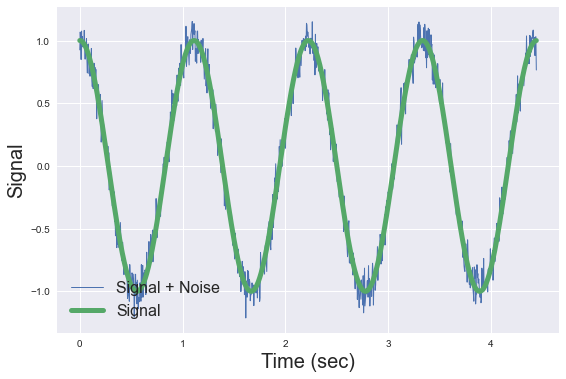

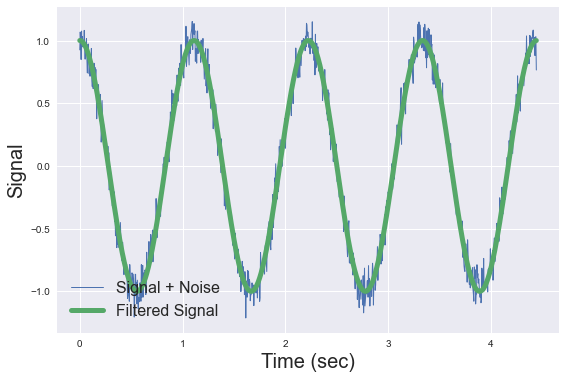

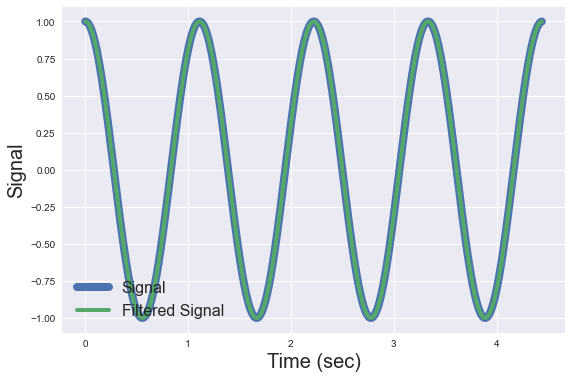

In [12]:
def make_data1():
    # -- Dummy data with noise
    cycles = 4                 # integer
    N = 2**10             # power of 2
    signal_freq = 0.9               # Hz
    noise_sigma = 0.3               #
    t_min = 0.0                    # sec
    t_max = cycles/signal_freq     # sec
    t, delta_t = np.linspace(
        t_min, 
        t_max, 
        N, 
        retstep=True, 
        endpoint=False
    )  # sec
    sampling_rate = 1.0 / delta_t            # Hz
    nyq_rate = sampling_rate / 2.0    # Hz
    cutoff_freq = 0.02 * nyq_rate         # Hz

    print("Sampling rate     : {0:4.3f} Hz.".format(sampling_rate))
    print("Nyquist frequency : {0:4.3f} Hz.".format(nyq_rate))
    print("Cutoff frequency  : {0:4.3f} Hz.".format(cutoff_freq))

    signal = np.cos(2*np.pi*signal_freq*t)
    noise = noise_sigma*np.random.normal(loc=0, scale=noise_sigma, size=N)
    
    return signal, noise, t, delta_t, sampling_rate, nyq_rate, cutoff_freq

signal, noise, t, delta_t, sampling_rate, nyq_rate, cutoff_freq = make_data1()

filtered_signal = sps.savgol_filter(signal, window_length=11, polyorder=5, mode='interp')

plt.figure(figsize=(9, 6))
plt.plot(t, signal+noise, label="Signal + Noise", linewidth=1)
plt.plot(t, signal, label="Signal", linewidth=5)
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()
plt.close()

plt.figure(figsize=(9, 6))
plt.plot(t, signal+noise, label="Signal + Noise", linewidth=1)
plt.plot(t, filtered_signal, label="Filtered Signal", linewidth=5)
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()
plt.close()

plt.figure(figsize=(9, 6))
plt.plot(t, signal, label="Signal", linewidth=8)
plt.plot(t, filtered_signal, label="Filtered Signal", linewidth=4)
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()
plt.close()


Sampling rate     : 920.700 Hz.
Nyquist frequency : 460.350 Hz.
Cutoff frequency  : 9.207 Hz.


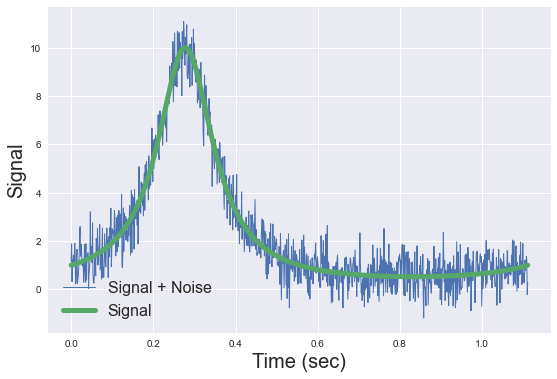

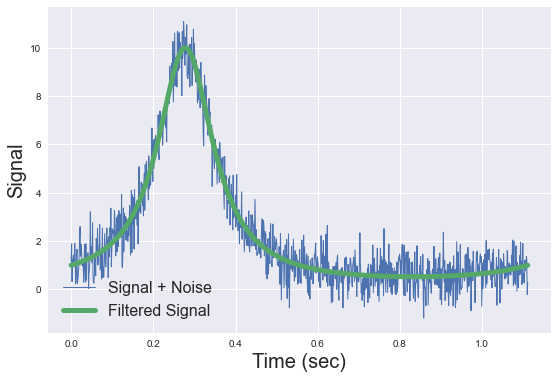

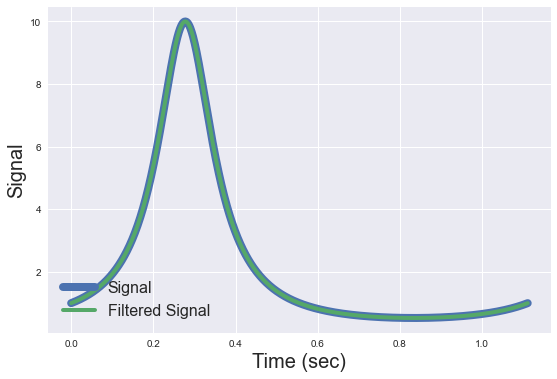

In [13]:
def make_data2():
    cycles = 1
    N = 2**10
    signal_freq = 0.9
    noise_sigma = 0.8
    t_min = 0
    t_max = cycles / signal_freq
    t, dt = np.linspace(t_min, t_max, N, retstep=True, endpoint=True)

    sampling_rate = 1 / dt
    nyq_rate = sampling_rate / 2
    cutoff_freq = 0.02 * nyq_rate

    print("Sampling rate     : {0:4.3f} Hz.".format(sampling_rate))
    print("Nyquist frequency : {0:4.3f} Hz.".format(nyq_rate))
    print("Cutoff frequency  : {0:4.3f} Hz.".format(cutoff_freq))

    signal = 1 / (1 - 0.9 * np.sin(2 * np.pi * signal_freq * t))
    noise = noise_sigma * np.random.normal(loc=0, scale=noise_sigma, size=N)
    
    return signal, noise, t, delta_t, sampling_rate, nyq_rate, cutoff_freq

signal, noise, t, delta_t, sampling_rate, nyq_rate, cutoff_freq = make_data2()

filtered_signal = sps.savgol_filter(signal, window_length=11, polyorder=5, mode='interp')

plt.figure(figsize=(9, 6))
plt.plot(t, signal+noise, label="Signal + Noise", linewidth=1)
plt.plot(t, signal, label="Signal", linewidth=5)
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()
plt.close()

plt.figure(figsize=(9, 6))
plt.plot(t, signal+noise, label="Signal + Noise", linewidth=1)
plt.plot(t, filtered_signal, label="Filtered Signal", linewidth=5)
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()
plt.close()

plt.figure(figsize=(9, 6))
plt.plot(t, signal, label="Signal", linewidth=8)
plt.plot(t, filtered_signal, label="Filtered Signal", linewidth=4)
plt.ylabel("Signal", fontsize=20)
plt.xlabel("Time (sec)", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()
plt.close()